##Define training parameters


In [ ]:
!pip install -q numpyro@git+https://github.com/pyro-ppl/numpyro
!pip install flowjax

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.9/178.9 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 4.9 MB/s eta 0:00:00


In [ ]:
# general
import os
import sys
import time
import numpy as np
import matplotlib.pyplot as plt

# Numpyro
import numpyro
import numpyro.distributions as npdist
import random as rnd
from numpyro.infer import Predictive, init_to_median, MCMC, NUTS
from numpyro.diagnostics import hpdi

#JAX
import jax
from jax import random, grad, jit
import jax.numpy as jnp
from jax.tree_util import tree_map

from flowjax.bijections import RationalQuadraticSpline
from flowjax.distributions import Normal
from flowjax.flows import masked_autoregressive_flow
from flowjax.tasks import two_moons
from flowjax.train import fit_to_data

numpyro.set_host_device_count(jax.local_device_count())
#pickle
import pickle

# check versions
print(numpyro.__version__)
print(jax.__version__)
from platform import python_version
print(python_version())

0.16.1
0.4.33
3.10.12


In [ ]:
# Set seed for reproducibility
#seed = 0
#key = jax.random.PRNGKey(seed)

# JAX automatically uses available hardware
print("JAX Device:", jax.devices()[0])

JAX Device: cuda:0


In [ ]:
# define global arguments
args = {"seed": 0,
        "conditional": True,
        "condition_dim":1,
        "input_dim": 80,
        "hidden_dim": 60,
        "batch_size": 500,
        "samples": 150000,
        "learning_rate": 1e-2,
        "n_epochs": 1000,
        "num_layers": 5,  # Add num_layers here
        "new_data": True,
        "train_nf": True,
        "save_nf": True,
        "load_nf": False,

        #"gp_kernel": exp_sq_kernel,
        "num_warmup": 2000,
        "num_samples": 5000,
        "num_chains": 3,
        "thinning": 1,
        "true_ls": 0.2
       }

## GP Priors

In [ ]:
def dist_euclid(x, z):
    x, z = jnp.array(x), jnp.array(z)
    x = x.reshape(-1, 1) if x.ndim == 1 else x
    z = z.reshape(-1, 1) if z.ndim == 1 else z
    n_x, m = x.shape
    n_z, m_z = z.shape
    assert m == m_z
    delta = jnp.zeros((n_x, n_z))
    for d in range(m):
        x_d = x[:, d]
        z_d = z[:, d]
        delta += (x_d[:, jnp.newaxis] - z_d) ** 2
    return jnp.sqrt(delta)

def exp_sq_kernel(x, z, var, length, noise=0, jitter=1.0e-5):
    dist = dist_euclid(x, z)
    deltaXsq = jnp.power(dist / length, 2.0)
    k = var * jnp.exp(-0.5 * deltaXsq)
    k += (noise + jitter) * jnp.eye(x.shape[0])
    return k

def GP(x, jitter=1e-5, var=1.0, length=None, y=None, noise=False, gp_kernel=exp_sq_kernel):

    if length==None:
        length = numpyro.sample("length", npdist.Uniform(0.01,0.99))

    k = gp_kernel(x, x, var, length, jitter)

    if noise==False:
        y = numpyro.sample("y",  npdist.MultivariateNormal(loc=jnp.zeros(x.shape[0]), covariance_matrix=k), obs=y)
    else:
        sigma = numpyro.sample("noise", npdist.HalfNormal(0.1))
        f = numpyro.sample("f", npdist.MultivariateNormal(loc=jnp.zeros(x.shape[0]), covariance_matrix=k))
        y = numpyro.sample("y", npdist.Normal(f, sigma), obs=y)

    ls = numpyro.deterministic("ls", jnp.array([length]))
    y_c = numpyro.deterministic("y_c", jnp.concatenate([y, ls], axis=0))

## Generate data - 1d GP

In [ ]:
class GP1D:
    def __init__(self, n_dataPoints=400,
                       n_samples=10000,
                       x_lim_low=0,
                       x_lim_high=1,
                       ls=None,
                       purpose = "train"
            ):
        self.n_dataPoints = n_dataPoints
        self.n_samples = n_samples
        self.x_lim_low = x_lim_low
        self.x_lim_high = x_lim_high
        self.ls = ls
        self.x, self.y, self.ls = self.__simulatedata__(purpose)

    def __simulatedata__(self,purpose):
        # Generate a JAX random key for reproducibility
        if purpose == "train":
          rng_key = 42
        else:
          rng_key = 24
        rng_key, _ = random.split(random.PRNGKey(rng_key))
        x = np.linspace(self.x_lim_low, self.x_lim_high, self.n_dataPoints)

        # Use Predictive from NumPyro to generate GP samples
        gp_predictive = Predictive(GP, num_samples=self.n_samples)
        all_draws = gp_predictive(rng_key, x=x, gp_kernel=exp_sq_kernel, jitter=1e-6, length=self.ls)

        # Extract samples and organize data
        ls_draws = np.array(all_draws['ls'])
        gp_draws = np.array(all_draws['y'])

        # Reshape x for compatibility with generated samples
        x_repeated = x.repeat(self.n_samples).reshape(self.n_dataPoints, self.n_samples).transpose()
        return x_repeated, gp_draws, ls_draws

    def __len__(self):
        return self.n_samples

    def get_item(self, idx=0):
        return self.x[idx], self.y[idx], self.ls[idx]

Input Dimension: 80
Shape of lengthscales: (10000, 1)


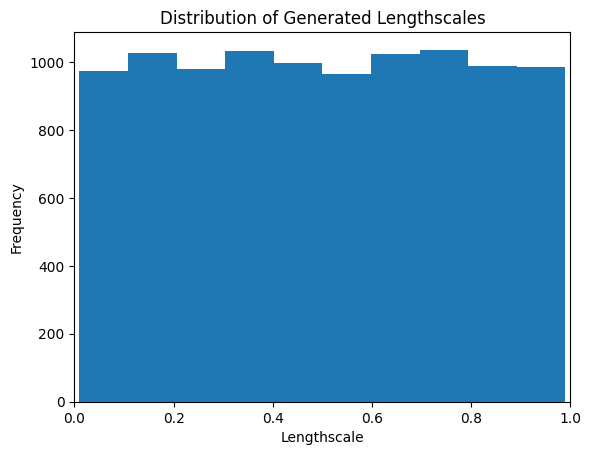

In [ ]:
# Print the input dimension being used
print("Input Dimension:", args["input_dim"])

# Create the dataset using the GP1D class
dataset = GP1D(n_dataPoints=args["input_dim"])

# Access the generated lengthscales
ls_dataset = dataset.ls
print("Shape of lengthscales:", ls_dataset.shape)

# Plot histogram of lengthscales
plt.hist(ls_dataset, bins=10)  # Adjust bin count for clarity if needed
plt.xlim(0, 1)
plt.xlabel("Lengthscale")
plt.ylabel("Frequency")
plt.title("Distribution of Generated Lengthscales")
plt.show()

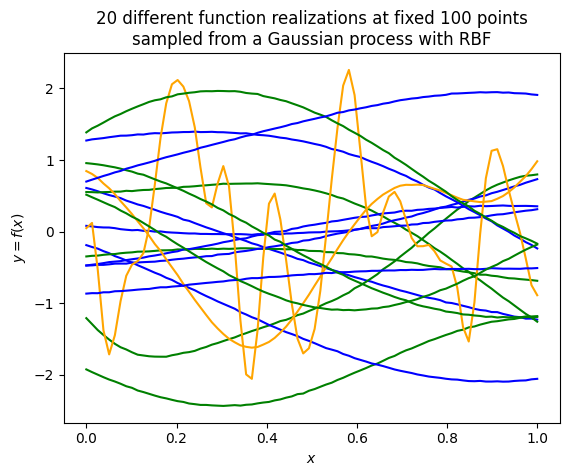

In [ ]:
# Initialize figure and axis for plotting
fig, ax = plt.subplots()

for no in range(len(dataset)):
    x, y, ls = dataset.get_item(no)

    # Determine color based on lengthscale
    if ls <= 0.2:
        col = 'orange'
    elif ls <= 0.6:
        col = 'green'
    else:
        col = 'blue'

    # Plot the function realization
    ax.plot(x.reshape(-1, 1), y.reshape(-1, 1), color=col)
    if no > 15: break

# Set plot labels and title
ax.set_xlabel('$x$')
ax.set_ylabel('$y=f(x)$')
ax.set_title('20 different function realizations at fixed 100 points\n'
             'sampled from a Gaussian process with RBF')

# Display the plot
plt.show()


Generating new data


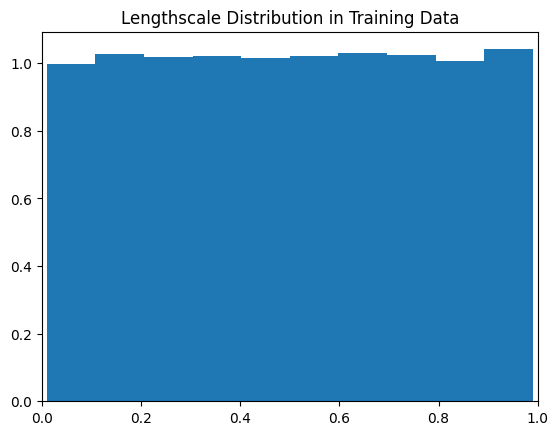

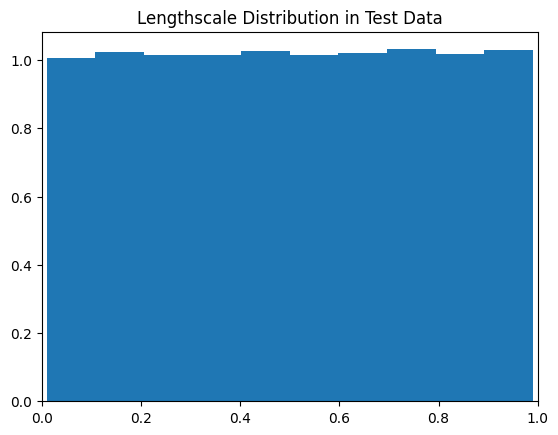

In [ ]:
###### create or read training and test data
cwd = os.getcwd()
train_ds_name = f'gp1d_n{args["input_dim"]}_train.pkl'
test_ds_name = f'gp1d_n{args["input_dim"]}_test.pkl'
PATH_train = os.path.join(cwd, "data", "gp1d", train_ds_name)
PATH_test = os.path.join(cwd, "data", "gp1d", test_ds_name)

# Ensure the directory exists
os.makedirs(os.path.dirname(PATH_train), exist_ok=True)
os.makedirs(os.path.dirname(PATH_test), exist_ok=True)

if args["new_data"]:
    print("Generating new data")
    train_ds = GP1D(n_dataPoints=args["input_dim"], n_samples=args["samples"],purpose = "train")
    test_ds = GP1D(n_dataPoints=args["input_dim"], n_samples=args["samples"],purpose = "test")
    # Save using pickle
    with open(PATH_train, 'wb') as f:
        pickle.dump(train_ds, f)
    with open(PATH_test, 'wb') as f:
        pickle.dump(test_ds, f)
else:
    print("Loading data")
    with open(PATH_train, 'rb') as f:
        train_ds = pickle.load(f)
    with open(PATH_test, 'rb') as f:
        test_ds = pickle.load(f)

# Manual batching function
def create_batches(dataset, batch_size):
    indices = np.arange(len(dataset))
    # np.random.shuffle(indices)
    for start_idx in range(0, len(dataset), batch_size):
        batch_indices = indices[start_idx:start_idx + batch_size]
        yield [dataset.get_item(i) for i in batch_indices]

# Example usage of create_batches for training and testing
train_batches = list(create_batches(train_ds, args["batch_size"]))
test_batches = list(create_batches(test_ds, args["batch_size"]))

# Check distribution of lengthscales in training and test data
plt.hist(train_ds.ls, density=True)
plt.xlim(0, 1)
plt.title("Lengthscale Distribution in Training Data")
plt.show()

plt.hist(test_ds.ls, density=True)
plt.xlim(0, 1)
plt.title("Lengthscale Distribution in Test Data")
plt.show()

## Conditional NF Architecture

In [ ]:
key, subkey = jax.random.split(jax.random.key(0))


## Defining model and training

In [ ]:
n_dim = args["input_dim"]
n_context = 1  # Single context parameter
n_samples = 20
# model = MaskedAutoregressiveFlow(n_dim=n_dim, n_context=n_context, hidden_dims=[128,128], n_transforms=12, activation="tanh", use_random_permutations=False)

flow = masked_autoregressive_flow(
    subkey,
    cond_dim = 1,
    base_dist=Normal(jnp.zeros(y.shape[0])),
    transformer=RationalQuadraticSpline(knots=8, interval=4),
)

In [ ]:
train_ds.y.shape

(150000, 80)

In [ ]:
train_ds.ls.shape

(150000, 1)

In [ ]:
key, subkey = jax.random.split(key)
flow, losses = fit_to_data(
    key=subkey,
    dist=flow,
    x=train_ds.y,
    condition=train_ds.ls,
    learning_rate=1e-4,
    max_patience=10,
    max_epochs = 200
)

 92%|█████████▏| 183/200 [26:22<02:27,  8.65s/it, train=-269, val=-266 (Max patience reached)]


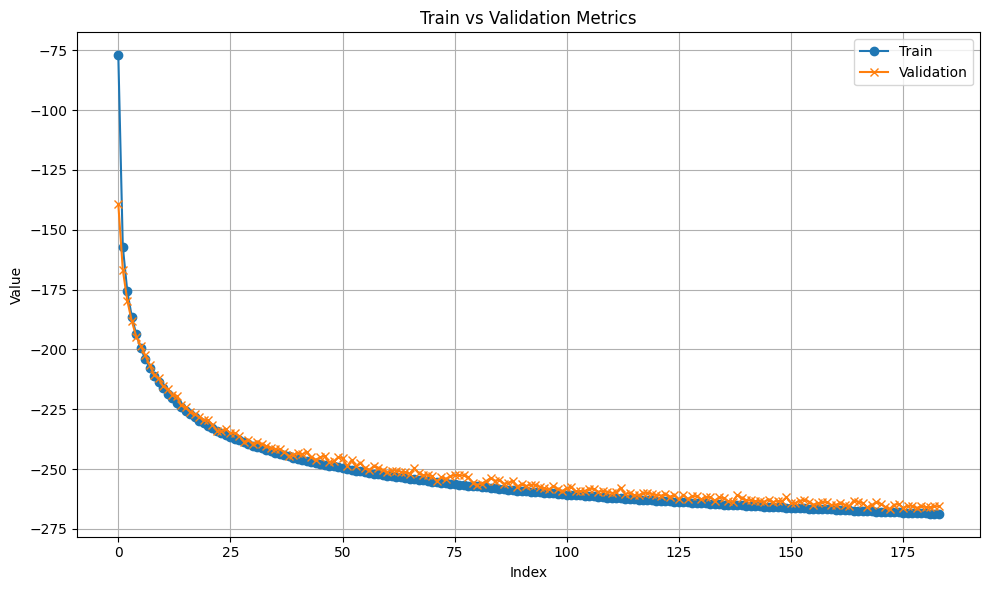

In [ ]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(losses['train'], label='Train', marker='o')
plt.plot(losses['val'], label='Validation', marker='x')
plt.title("Train vs Validation Metrics")
plt.xlabel("Index")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
flow.sample(subkey,condition = np.array([0.23]))

Array([-0.2637775 , -0.3680929 , -0.46150497, -0.5308547 , -0.62253743,
       -0.69466394, -0.7805875 , -0.849625  , -0.9217618 , -0.9789825 ,
       -1.0251567 , -1.0667832 , -1.1027474 , -1.1352785 , -1.1538018 ,
       -1.180038  , -1.1886938 , -1.2000766 , -1.1906147 , -1.2051247 ,
       -1.1822549 , -1.1866062 , -1.1761035 , -1.158416  , -1.1795464 ,
       -1.1773496 , -1.1787274 , -1.1913583 , -1.2016722 , -1.2235184 ,
       -1.253558  , -1.2929327 , -1.3333169 , -1.3884174 , -1.4415219 ,
       -1.5142474 , -1.5796136 , -1.655069  , -1.7338187 , -1.8329787 ,
       -1.9243304 , -1.9855957 , -2.0910633 , -2.1724665 , -2.2392256 ,
       -2.31414   , -2.3660169 , -2.4387233 , -2.4820154 , -2.5047605 ,
       -2.5416005 , -2.5420232 , -2.5425994 , -2.5607355 , -2.5240364 ,
       -2.4713383 , -2.4241655 , -2.355817  , -2.2674813 , -2.1795912 ,
       -2.076773  , -1.9650898 , -1.8425623 , -1.7136878 , -1.5658271 ,
       -1.4439313 , -1.2843206 , -1.1612902 , -1.0143754 , -0.87

In [ ]:
flow.sample(subkey,condition = np.array([0.59]))

Array([ 0.07692498,  0.06785148,  0.04930061,  0.04857495,  0.03491831,
        0.02550596,  0.01327932,  0.00486729, -0.00770575, -0.02278644,
       -0.02989188, -0.03932929, -0.05147451, -0.06659621, -0.08098069,
       -0.09167472, -0.0991399 , -0.11675599, -0.12515634, -0.14803806,
       -0.15328026, -0.17652705, -0.18042779, -0.19668084, -0.2184577 ,
       -0.23262289, -0.24220759, -0.2615238 , -0.2725988 , -0.28933716,
       -0.30260447, -0.32465664, -0.3317383 , -0.35619888, -0.3656328 ,
       -0.38150457, -0.39247137, -0.4052012 , -0.4163821 , -0.43627173,
       -0.45209932, -0.4591519 , -0.47193623, -0.48280904, -0.49064934,
       -0.50458634, -0.5053231 , -0.51604974, -0.525326  , -0.51627433,
       -0.52796274, -0.5221057 , -0.5222624 , -0.5370071 , -0.5315149 ,
       -0.5271947 , -0.52925617, -0.51755244, -0.50659966, -0.4935672 ,
       -0.4900543 , -0.47767627, -0.46553284, -0.45036793, -0.43337256,
       -0.41625977, -0.39549702, -0.3807836 , -0.3551418 , -0.32

## Post training operations

In [ ]:
def MMD(x, y, kernel="multiscale"):
    """
    Empirical Maximum Mean Discrepancy (MMD). A lower value indicates that the distributions P and Q are closer.

    Args:
        x: jnp.ndarray, first sample (distribution P) with shape (n_samples, n_features)
        y: jnp.ndarray, second sample (distribution Q) with shape (n_samples, n_features)
        kernel: str, type of kernel to use ("multiscale" or "rbf")

    Returns:
        MMD value as a scalar (jnp.float32)
    """
    # Compute pairwise squared distances
    def squared_distances(a, b):
        a_sq = jnp.sum(a**2, axis=1, keepdims=True)
        b_sq = jnp.sum(b**2, axis=1, keepdims=True)
        cross_term = jnp.dot(a, b.T)
        return a_sq + b_sq.T - 2 * cross_term

    dxx = squared_distances(x, x)  # Pairwise distances in P
    dyy = squared_distances(y, y)  # Pairwise distances in Q
    dxy = squared_distances(x, y)  # Pairwise distances between P and Q

    # Initialize result matrices
    XX = jnp.zeros_like(dxx)
    YY = jnp.zeros_like(dyy)
    XY = jnp.zeros_like(dxy)

    # Apply kernel functions
    if kernel == "multiscale":
        bandwidth_range = [0.2, 0.5, 0.9, 1.3]
        for a in bandwidth_range:
            XX += a**2 / (a**2 + dxx)
            YY += a**2 / (a**2 + dyy)
            XY += a**2 / (a**2 + dxy)

    elif kernel == "rbf":
        bandwidth_range = [10, 15, 20, 50]
        for a in bandwidth_range:
            XX += jnp.exp(-0.5 * dxx / a)
            YY += jnp.exp(-0.5 * dyy / a)
            XY += jnp.exp(-0.5 * dxy / a)

    return jnp.mean(XX + YY - 2 * XY)


In [ ]:
def demo_plots(conditional=False,
               ttl1="GP priors to encode",
               ttl2="Priors learnt by NF",
               ylbl1='$y=f_{GP}(x)$',
               ylbl2='$y=f_{NF}(x)$',
               ls=None):

    n_samps = 100
    dataset = GP1D(n_dataPoints=args["input_dim"], n_samples=n_samps, ls=ls)
    # print(dataset)
    gp_draws = dataset.y
    # print("GP Draws:", gp_draws)
    x = dataset.x[0, :]
    # print("x",x)
    gp_draws = gp_draws.T

    # Update titles and labels if conditional
    if conditional:
        ttl2 = "Priors learnt by CNF"
        ylbl2 = '$y=f_{CNF}(x)$'

    # Generate VAE draws
    if conditional:
        # print(c)
        vae_draws = flow.sample(subkey,condition = dataset.ls).T
        print(vae_draws.shape)

    # Calculate quantiles and means
    # print("vae_draws",vae_draws)
    mean_gp = jnp.nanmean(gp_draws, axis=1)
    q025_gp = jnp.quantile(gp_draws, 0.025, axis=1)
    q975_gp = jnp.quantile(gp_draws, 0.975, axis=1)

    mean_vae = jnp.nanmean(vae_draws, axis=1)
    q025_vae = jnp.quantile(vae_draws, 0.025, axis=1)
    q975_vae = jnp.quantile(vae_draws, 0.975, axis=1)

    #print("q025: ")
    #print(q025_gp)
    #print(q025_vae)
    #print("q975: ")
    #print(q975_gp)
    #print(q975_vae)

    # Plot results
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 3))
    _min, _max = -3, 3
    lines_alpha_gp = 0.5
    lines_alpha_vae = 0.5
    N_lines = 20

    # Plot GP draws
    for j in range(N_lines):
        itr = int(gp_draws.shape[1] / N_lines)
        axs[0].plot(x, gp_draws[:, j * itr], alpha=lines_alpha_gp, label="")

    axs[0].plot(x, gp_draws[:,0], alpha=lines_alpha_gp, color="darkgreen", label="GP draws")
    axs[0].fill_between(x, q025_gp, q975_gp, alpha=0.1, label="95% BCI")
    axs[0].plot(x, mean_gp, label="mean")
    axs[0].legend(loc=4)
    axs[0].set_ylim([_min, _max])
    axs[0].set_xlabel('$x$')
    axs[0].set_ylabel(ylbl1)
    axs[0].set_title(ttl1 if ls is None else f"{ttl1}, ls={ls}")

    # Plot VAE draws
    for j in range(N_lines):
        itr = int(vae_draws.shape[1] / N_lines)
        axs[1].plot(x, vae_draws[:, j * itr], alpha=lines_alpha_vae)

    axs[1].plot(x, vae_draws[:,0], alpha=lines_alpha_vae, color="darkgreen", label="VAE draws")
    axs[1].fill_between(x, q025_vae, q975_vae, alpha=0.1, label="95% BCI")
    axs[1].plot(x, mean_vae, label="mean")
    axs[1].legend(loc=4)
    axs[1].set_ylim([_min, _max])
    axs[1].set_xlabel('$x$')
    axs[1].set_ylabel(ylbl2)
    axs[1].set_title(ttl2 if ls is None else f"{ttl2}, ls={ls}")

    # Combined plot for GP and VAE means
    axs[2].fill_between(x, q025_gp, q975_gp, alpha=0.1)
    axs[2].plot(x, mean_gp, label="GP mean")
    axs[2].plot(x, mean_vae, label="VAE mean")
    axs[2].legend(loc=4)
    axs[2].set_ylim([_min, _max])

    plt.show()

    # Covariance matrices
    m_vae = np.cov(vae_draws)
    m_gp = np.cov(gp_draws)
    print('Frobenius norm =', np.linalg.norm(m_gp - m_vae, 'fro'))

    # MMD calculation
    print('MMD, multiscale =', MMD(jnp.array(gp_draws), jnp.array(vae_draws)))
    print('MMD, rbf =', MMD(jnp.array(gp_draws), jnp.array(vae_draws), "rbf"))

    # Covariance matrix plots
    cmap_choice = 'inferno'
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
    axs[0].imshow(m_gp, cmap=cmap_choice)
    axs[0].axis('off')
    axs[0].set_title(f'GP covariance matrix{", c=" + str(ls) if ls is not None else ""}')

    axs[1].imshow(m_vae, cmap=cmap_choice)
    axs[1].axis('off')
    axs[1].set_title(f'VAE covariance matrix{", c=" + str(ls) if ls is not None else ""}')

    plt.show()

(80, 100)


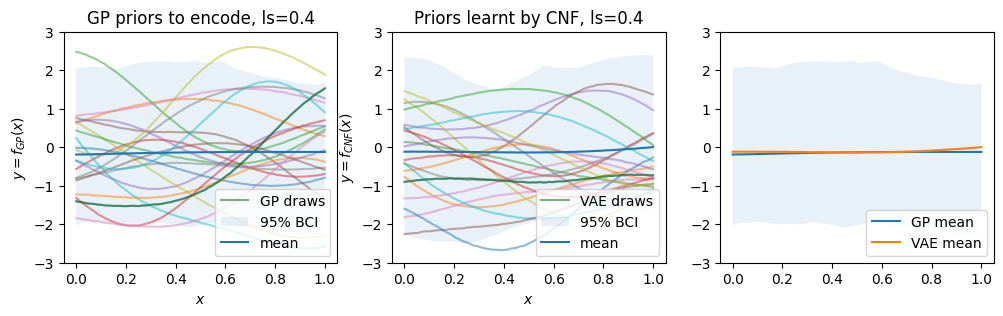

Frobenius norm = 8.263698742702246
MMD, multiscale = 0.5786849
MMD, rbf = 3.173967


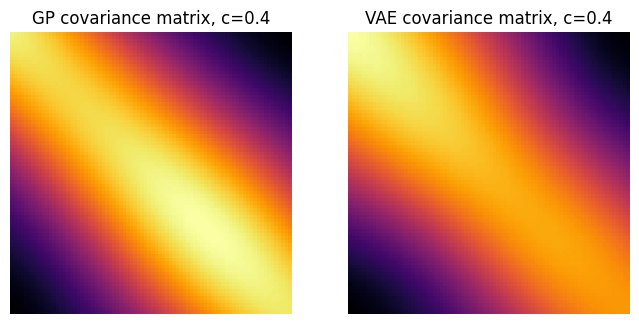

In [ ]:
# 2).
np.random.seed(36)
demo_plots(conditional=True, ls=0.4)

(80, 100)


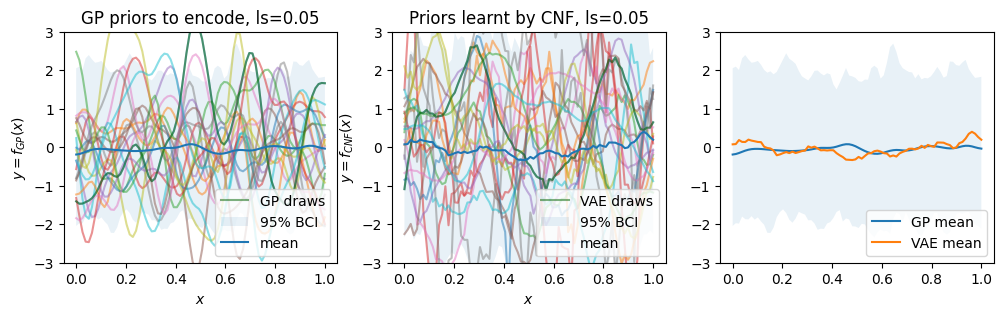

Frobenius norm = 65.99327860433405
MMD, multiscale = 0.13259687
MMD, rbf = 0.47143644


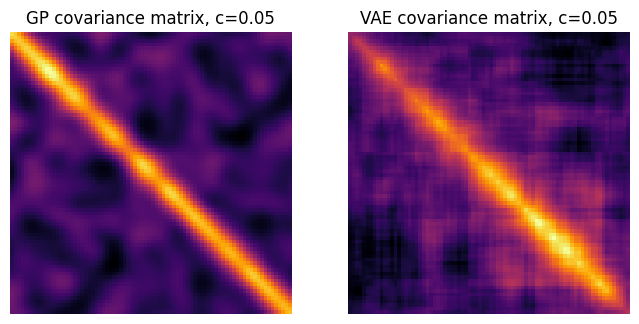

In [ ]:
# 3).
demo_plots(conditional=True, ls=0.05)

(80, 100)


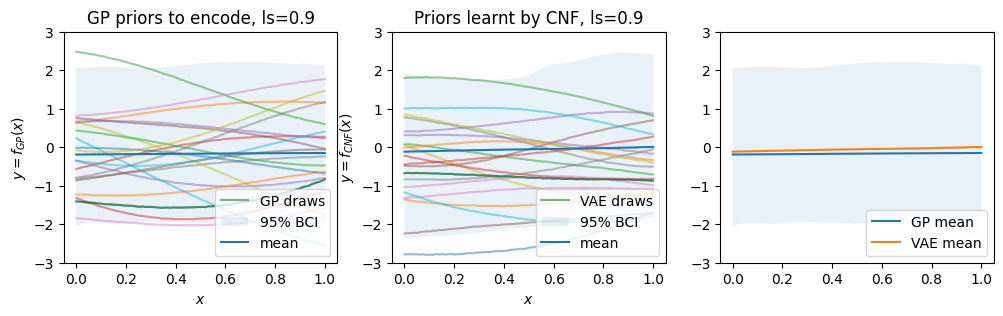

Frobenius norm = 3.2743338380708154
MMD, multiscale = 1.265299
MMD, rbf = 5.122424


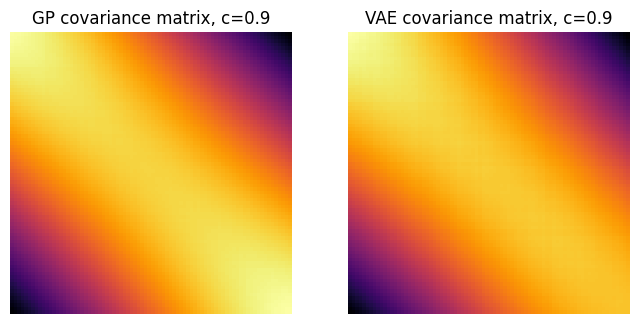

In [ ]:
# 4).
demo_plots(conditional=True, ls=0.9)

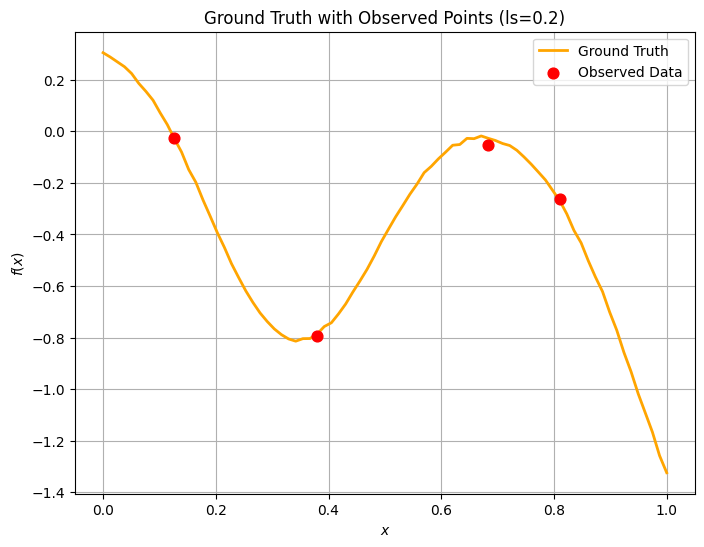

In [ ]:
# Define x and initialize random keys
x, y, ls = train_ds.get_item(0)  # Use get_item to fetch the first data point

# Initialize random keys for JAX
rng_key_draw = jax.random.PRNGKey(1)
rng_key, rng_key_post, rng_key_preds, rng_key_draw = jax.random.split(rng_key_draw, 4)

# GP Predictive sampling
gp_predictive = Predictive(GP, num_samples=1)
draws = gp_predictive(
    rng_key_draw, x=x, jitter=1e-6,
    noise=True, length=args["true_ls"], var=1
)

gp_draw = draws['f'].T  # GP function draws
y_draw = draws['y'].T  # GP noisy observations

# Define observed indices and select observed data points
obs_idx_lst = [
    # [10, 32, 36, 48, 53, 70, 85],  # for ls=0.05
    # [5, 10, 20, 33, 44],           # for n=50, ls=0.2
    # [25, 28, 70],                  # for n=80, ls=0.3
    [10, 30, 54, 64],                # for n=80, ls=0.2
    # [15, 54, 63]                   # for n=80, ls=0.5
]
i = 0  # Choose the first set of indices

obs_idx = jnp.array(obs_idx_lst[i])  # Observed indices
y_obs = y_draw[obs_idx, 0]  # Observed outputs
x_obs = x[np.array(obs_idx)]  # Observed inputs

# Store observed data in args for later use
args["y_obs"] = y_obs
args["obs_idx"] = obs_idx
args["x_obs"] = x_obs

# Plot ground truth and observed points
plt.figure(figsize=(8, 6))
plt.plot(x, gp_draw, label="Ground Truth", color="orange", linewidth=2)
plt.scatter(x_obs, y_obs, color="red", label="Observed Data", s=60, zorder=5)
plt.title(f"Ground Truth with Observed Points (ls={args['true_ls']})")
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from flowjax.experimental.numpyro import sample
from flowjax.distributions import Normal

def numpyro_nf_model(conditional=False, y_dim = 80,y=None, obs_idx=None, c=None,):
    if c is None and conditional==True:
        c = numpyro.sample("c", npdist.Uniform(0.01,0.99))

    z = sample("z", Normal(jnp.zeros(y_dim)))

    f = numpyro.deterministic("f", flow.bijection.transform(z,condition = c.reshape(1)))

    sigma = numpyro.sample("sigma", npdist.HalfNormal(0.1))

    if y is None: # durinig prediction
        y_pred = numpyro.sample("y_pred", npdist.Normal(f, sigma))
    else: # during inference
        y = numpyro.sample("y", npdist.Normal(f[obs_idx], sigma), obs=y)

In [ ]:
def run_mcmc_nf(rng_key, numpyro_model, args,  verbose=True, c=None, conditional=False):
    """
    Run MCMC for the Normalizing Flow model.

    Args:
        rng_key: PRNG key for randomness.
        numpyro_model: NumPyro model function.
        args: Dictionary of arguments (e.g., num_samples, num_warmup).
        verbose: bool, whether to print MCMC summary and diagnostics.
        c: Conditional input (optional).
        conditional: bool, whether the model is conditional.

    Returns:
        mcmc: MCMC object.
        samples: Posterior samples.
        t_elapsed: Time taken for MCMC.
    """
    import time
    from numpyro.infer import MCMC, NUTS
    import numpyro.diagnostics

    # Start timing
    start = time.time()

    # Initialize the NUTS kernel with median-based initialization
    init_strategy = init_to_median(num_samples=100)
    kernel = NUTS(numpyro_nf_model, init_strategy=init_strategy)

    mcmc = MCMC(
        kernel,
        num_warmup=300,
        num_samples=100,
        num_chains=1,
        thinning=args["thinning"],
        progress_bar=True if "NUMPYRO_SPHINXBUILD" not in os.environ else False,
    )

    print("Running MCMC...")
    print(conditional,c,args["y_obs"],args["obs_idx"])
    mcmc.run(rng_key=rng_key,conditional = conditional, y_dim = 80,y=args["y_obs"], obs_idx=args["obs_idx"], c=c)
    t_elapsed = time.time() - start

    if verbose:
        mcmc.print_summary(exclude_deterministic=False)

    print("\nMCMC elapsed time:", round(t_elapsed), "s")

    # Extract diagnostics and summarize Effective Sample Size (ESS)
    diagnostics = numpyro.diagnostics.summary(mcmc.get_samples(group_by_chain=True))
    avg_ess = np.mean(diagnostics["f"]["n_eff"])
    print("Average ESS for NF effects:", round(avg_ess))

    return mcmc, mcmc.get_samples(), t_elapsed


In [ ]:
print(args["obs_idx"])

[10 30 54 64]


In [ ]:
args.keys()

dict_keys(['seed', 'conditional', 'condition_dim', 'input_dim', 'hidden_dim', 'batch_size', 'samples', 'learning_rate', 'n_epochs', 'num_layers', 'new_data', 'train_nf', 'save_nf', 'load_nf', 'num_warmup', 'num_samples', 'num_chains', 'thinning', 'true_ls', 'y_obs', 'obs_idx', 'x_obs'])

In [ ]:
mcmc_vae, mcmc_vae_samples, t_elapsed = run_mcmc_nf(jax.random.PRNGKey(27), numpyro_nf_model, args, conditional=True)

Running MCMC...
True None [-0.02666425 -0.7934161  -0.05228634 -0.26394078] [10 30 54 64]


sample: 100%|██████████| 400/400 [2:06:14<00:00, 18.94s/it, 127 steps of size 3.20e-02. acc. prob=0.61]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         c      0.33      0.16      0.30      0.11      0.53     31.65      1.00
      f[0]      0.38      0.56      0.31     -0.53      1.15     22.11      0.99
      f[1]      0.34      0.50      0.26     -0.46      1.02     22.01      0.99
      f[2]      0.31      0.45      0.22     -0.49      0.83     22.66      0.99
      f[3]      0.27      0.40      0.20     -0.38      0.79     23.26      1.00
      f[4]      0.21      0.35      0.17     -0.45      0.60     23.39      1.00
      f[5]      0.16      0.30      0.16     -0.35      0.56     23.56      1.00
      f[6]      0.12      0.26      0.12     -0.36      0.45     25.42      1.00
      f[7]      0.07      0.22      0.07     -0.35      0.35     26.56      1.00
      f[8]      0.01      0.20      0.04     -0.37      0.27     30.95      1.00
      f[9]     -0.04      0.17     -0.01     -0.38      0.21     45.27      0.99
     f[10]     -0.09      0

(-2.0, 1.0)

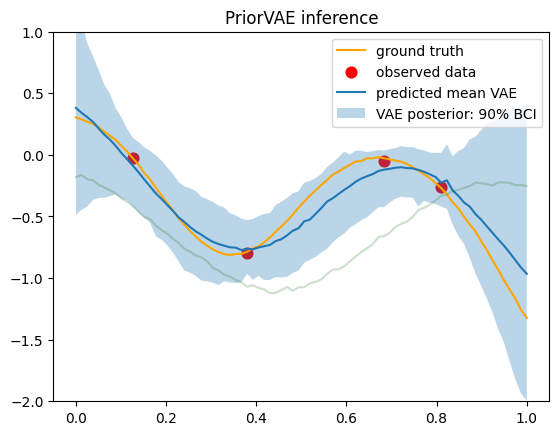

In [ ]:
predictive = Predictive(numpyro_nf_model, mcmc_vae_samples)
predictions_vae = predictive(jax.random.PRNGKey(7),  y_dim = 80, conditional = True, y =args["y_obs"],obs_idx= args["obs_idx"] )["f"]

mean_post_pred_vae = jnp.mean(predictions_vae, axis=0)
hpdi_post_pred_vae = hpdi(predictions_vae, 0.9)
percentiles_vae = np.percentile(predictions_vae, [5.0, 95.0], axis=0)

N_lines = 1
plt.plot(x, gp_draw, label="ground truth", color="orange")
plt.scatter(x_obs, y_obs, color="red", label="observed data", s=60)
plt.plot(x, mean_post_pred_vae, label="predicted mean VAE")

plt.fill_between(x, percentiles_vae[0, :], percentiles_vae[1, :], alpha=0.3, interpolate=True, label="VAE posterior: 90% BCI")
for j in range(N_lines):
    itr = int(predictions_vae.shape[0]/N_lines)
    plt.plot(x, predictions_vae[j* itr,:], alpha=0.2, color="darkgreen", label="")
    #plt.plot(x, predictions_vae[j,:], alpha=0.2, color="darkgreen", label="")

plt.title('PriorVAE inference')
plt.legend(loc=1)
plt.ylim([-2, 1])


In [ ]:
predictive(jax.random.PRNGKey(7),  y_dim = 80, conditional = True, y =args["y_obs"],obs_idx= args["obs_idx"] )

{'f': Array([[-0.18079323, -0.16402951, -0.19886768, ..., -0.24648124,
         -0.24395424, -0.25364643],
        [-0.067496  , -0.06389266, -0.11552325, ..., -0.12614006,
         -0.10159627, -0.09078234],
        [ 0.28865695,  0.2665401 ,  0.22518718, ..., -0.4859169 ,
         -0.5150487 , -0.5694725 ],
        ...,
        [ 0.6709012 ,  0.56608963,  0.47054577, ..., -1.2122564 ,
         -1.3001709 , -1.3630114 ],
        [ 0.8431747 ,  0.7551205 ,  0.6454344 , ..., -1.1452963 ,
         -1.2386138 , -1.3317562 ],
        [ 1.3568567 ,  1.2448583 ,  1.1157639 , ..., -0.82857996,
         -0.8698907 , -0.8804717 ]], dtype=float32),
 'y': Array([[-0.02666425, -0.7934161 , -0.05228634, -0.26394078],
        [-0.02666425, -0.7934161 , -0.05228634, -0.26394078],
        [-0.02666425, -0.7934161 , -0.05228634, -0.26394078],
        [-0.02666425, -0.7934161 , -0.05228634, -0.26394078],
        [-0.02666425, -0.7934161 , -0.05228634, -0.26394078],
        [-0.02666425, -0.7934161 , -0.

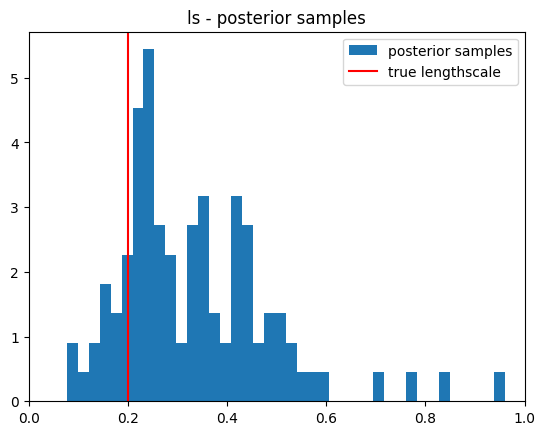

In [ ]:
c_samps = mcmc_vae_samples['c']
plt.hist(c_samps, density=True, label = 'posterior samples', bins=40)
plt.axvline(x = args["true_ls"], color = 'red', label = 'true lengthscale')
plt.xlim(0,1)
plt.title('ls - posterior samples')
plt.legend()

array([[<Axes: title={'center': 'c'}>, <Axes: title={'center': 'c'}>]],
      dtype=object)

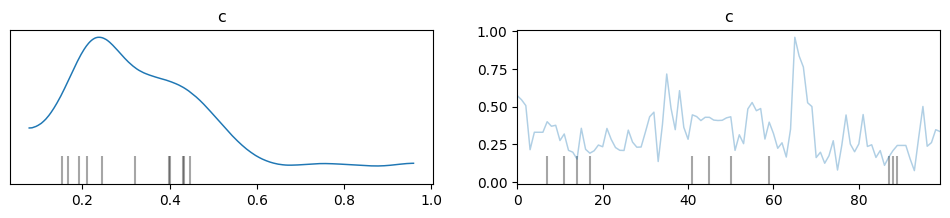

In [ ]:
import arviz as az
az_data = az.from_numpyro(mcmc_vae)
#az.plot_trace(az_data, var_names=('f'), filter_vars="like")
az.plot_trace(az_data, var_names=('c'), filter_vars="like")

In [ ]:
true_ls_lst = [0.2, 0.3, 0.5]
rng_key_lst = [jax.random.PRNGKey(1), jax.random.PRNGKey(2), jax.random.PRNGKey(1)]

obs_idx_lst = [
    [10, 30, 54, 64],
    [25, 28, 70],
    [15, 54, 63]
]

mean_post_pred_lst = []
perc_post_pred_lst = []
x_obs_lst = []
y_obs_lst = []
predictions_lst = []
c_samps_lst = []
gp_draw_lst = []

# Generate x values from the dataset
x = train_ds.get_item(0)[0]  # Assuming train_ds is accessed via get_item

for i in range(len(true_ls_lst)):
    true_ls = true_ls_lst[i]
    rng_key_draw = rng_key_lst[i]

    # Generate random keys for sampling and inference
    rng_key, rng_key_post, rng_key_preds, rng_key_draw = jax.random.split(rng_key_draw, 4)

    # GP Predictive sampling
    gp_predictive = Predictive(GP, num_samples=1)
    draws = gp_predictive(rng_key_draw, x=x, jitter=1e-6, noise=True, length=true_ls, var=1)

    gp_draw = draws['f'].T
    y_draw = draws['y'].T

    # Select observed indices for inference
    obs_idx = jnp.array(obs_idx_lst[i])
    y_obs = y_draw[obs_idx, 0]
    x_obs = x[obs_idx]

    # Update arguments for MCMC
    args['y_obs'] = y_obs
    args['obs_idx'] = obs_idx
    args['x_obs'] = x_obs

    # Run MCMC inference
    mcmc_vae, mcmc_vae_samples, t_elapsed = run_mcmc_nf(rng_key_post, numpyro_nf_model, args, conditional=True)

    # Posterior predictions
    predictive = Predictive(numpyro_nf_model, mcmc_vae_samples)
    predictions_vae = predictive(rng_key_preds, conditional = True,y_dim = True, c=None)["f"]

    mean_post_pred_vae = jnp.mean(predictions_vae, axis=0)
    percentiles_vae = np.percentile(predictions_vae, [5.0, 95.0], axis=0)
    c_samps = mcmc_vae_samples['c']

    # Store results
    mean_post_pred_lst.append(mean_post_pred_vae)
    perc_post_pred_lst.append(percentiles_vae)
    gp_draw_lst.append(gp_draw)
    x_obs_lst.append(x_obs)
    y_obs_lst.append(y_obs)
    predictions_lst.append(predictions_vae)
    c_samps_lst.append(c_samps)


Running MCMC...
True None [-0.02666425 -0.7934161  -0.05228634 -0.26394078] [10 30 54 64]


sample: 100%|██████████| 400/400 [3:40:26<00:00, 33.07s/it, 63 steps of size 5.40e-02. acc. prob=0.74]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         c      0.45      0.21      0.40      0.19      0.84     11.83      1.03
      f[0]      0.28      0.49      0.28     -0.75      0.88     35.28      1.00
      f[1]      0.23      0.45      0.24     -0.72      0.76     36.21      1.00
      f[2]      0.22      0.41      0.23     -0.69      0.72     35.99      0.99
      f[3]      0.17      0.37      0.18     -0.64      0.60     37.44      1.00
      f[4]      0.14      0.34      0.18     -0.58      0.57     38.93      0.99
      f[5]      0.12      0.31      0.17     -0.54      0.52     39.96      0.99
      f[6]      0.08      0.28      0.12     -0.52      0.42     43.50      0.99
      f[7]      0.06      0.25      0.08     -0.42      0.41     45.90      0.99
      f[8]      0.01      0.22      0.04     -0.29      0.40     58.21      0.99
      f[9]     -0.02      0.21      0.03     -0.35      0.30     56.80      1.00
     f[10]     -0.08      0

sample: 100%|██████████| 400/400 [5:01:13<00:00, 45.18s/it, 511 steps of size 1.07e-02. acc. prob=0.86]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         c      0.49      0.20      0.47      0.10      0.77     40.21      0.99
      f[0]      0.97      1.22      1.16     -1.00      2.90     58.65      0.99
      f[1]      0.98      1.17      1.16     -0.92      2.84     58.19      0.99
      f[2]      1.00      1.12      1.17     -1.12      2.53     58.40      0.99
      f[3]      1.01      1.09      1.16     -0.97      2.51     59.48      0.99
      f[4]      1.02      1.05      1.14     -0.87      2.46     58.92      0.99
      f[5]      1.02      1.01      1.12     -0.76      2.45     59.38      0.99
      f[6]      1.04      0.97      1.12     -0.55      2.47     59.95      0.99
      f[7]      1.04      0.92      1.10     -0.48      2.42     59.81      0.99
      f[8]      1.04      0.88      1.08     -0.35      2.37     59.80      0.99
      f[9]      1.04      0.83      1.07     -0.24      2.31     60.06      0.99
     f[10]      1.04      0

sample: 100%|██████████| 400/400 [2:39:15<00:00, 23.89s/it, 127 steps of size 4.93e-02. acc. prob=0.59]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         c      0.64      0.19      0.63      0.36      0.95     18.60      1.01
      f[0]      0.47      0.40      0.50     -0.07      1.08     25.64      1.03
      f[1]      0.45      0.37      0.47     -0.02      1.03     25.58      1.02
      f[2]      0.43      0.35      0.45     -0.04      0.95     25.61      1.02
      f[3]      0.41      0.33      0.42     -0.10      0.82     25.81      1.01
      f[4]      0.39      0.30      0.39     -0.04      0.80     25.96      1.00
      f[5]      0.37      0.28      0.38     -0.01      0.76     26.24      0.99
      f[6]      0.35      0.27      0.34      0.02      0.71     26.49      0.99
      f[7]      0.32      0.24      0.32      0.02      0.67     26.05      0.99
      f[8]      0.29      0.22      0.29      0.05      0.63     26.30      0.99
      f[9]      0.26      0.20      0.28      0.04      0.61     25.76      0.99
     f[10]      0.23      0

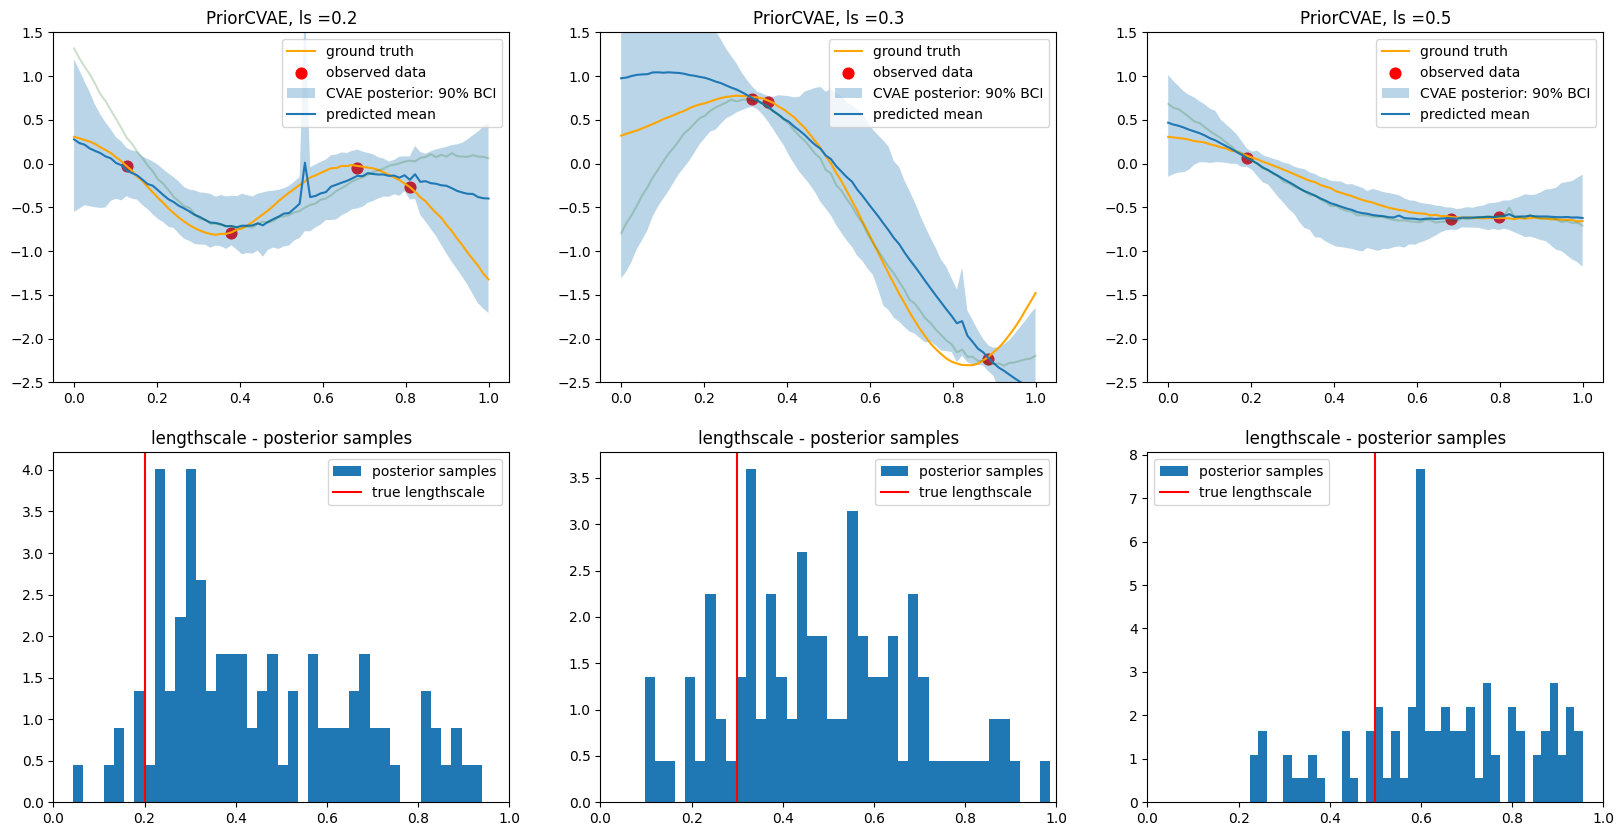

In [ ]:
# plot results
fig, axs = plt.subplots(nrows=2, ncols=len(mean_post_pred_lst), figsize=(20,10))
_min, _max = np.amin(mean_post_pred_lst), np.amax(mean_post_pred_lst)

for i in range(len(mean_post_pred_lst)):
    axs[0,i].plot(x, gp_draw_lst[i], label="ground truth", color="orange")
    axs[0,i].scatter(x_obs_lst[i], y_obs_lst[i], color="red", label="observed data", s=60)
    axs[0,i].fill_between(x,
                      perc_post_pred_lst[i][0], perc_post_pred_lst[i][1],
                      alpha=0.3, interpolate=True, label="CVAE posterior: 90% BCI")
    axs[0,i].plot(x, mean_post_pred_lst[i], label="predicted mean")
    for j in range(N_lines):
        itr = int(predictions_lst[i].shape[0]/N_lines)
        axs[0,i].plot(x, predictions_lst[i][j* itr,:], alpha=0.2, color="darkgreen", label="")
    axs[0,i].set_title('PriorCVAE, ls =' + str(true_ls_lst[i]))
    axs[0,i].legend(loc=1)
    axs[0, i].set_ylim(-2.5, 1.5)

    axs[1,i].hist(c_samps_lst[i], density=True, label = 'posterior samples', bins=40)
    axs[1,i].axvline(x = true_ls_lst[i], color = 'red', label = 'true lengthscale')
    axs[1,i].set_xlim(0,1)
    axs[1,i].set_title('lengthscale - posterior samples')
    axs[1,i].legend()